### Training

In [1]:
import torch
torch.cuda.is_available()
device=torch.device("cuda:0")
device
if torch.cuda.is_available():
  device=torch.device("cuda:0")
  print("running on gpu")
else:
  device=torch.device("cpu")
  print("running on cpu")

torch.cuda.device_count()

running on cpu


0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Input,UpSampling2D,Conv2DTranspose
#from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#1.dataset loading

In [ ]:
#1.dataset loading
path = "/content/drive/MyDrive/Resized_Images/Train/Unlabeled/"
#path= '/content/drive/MyDrive/UOL files/Dissertation Project/FloodNet-Supervised_v1.0/test/test-org-img/'

data=[]
for img in os.listdir(path):
    k = os.path.join(path,img)
    d = cv2.imread(k)#BGR
    #d = cv2.resize(d,(512,768,3))
    data.append(d)


#splitting data
X_train, X_test, Y_train, Y_test = train_test_split(data,data,test_size=0.1, random_state=42)

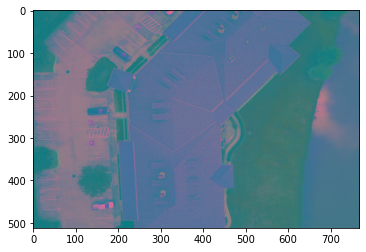

In [ ]:
#2.RGB to Ycbcr
converted_x_train = []
for x in range(len(X_train)):
    k = cv2.cvtColor(X_train[x],cv2.COLOR_BGR2YCR_CB)#
    k = cv2.resize(k,(768,512))
    Y_train[x]=cv2.resize(Y_train[x],(768,512))
    converted_x_train.append(k)

converted_x_test = []
for x in range(len(X_test)):
    k = cv2.cvtColor(X_test[x],cv2.COLOR_BGR2YCR_CB)#
    k = cv2.resize(k,(768,512))
    Y_test[x]=cv2.resize(Y_test[x],(768,512))
    converted_x_test.append(k)

plt.imshow(converted_x_test[4])

In [ ]:
del X_train
del X_test
del Y_train
del Y_test
del data

In [ ]:
#3.scaling
x_train=converted_x_train
x_test=converted_x_test
#print(x_train[4].shape)
#print(x_train[4])
#print(x_test[2].shape)

x_train= np.array(x_train, dtype = np.float32)/255.0
x_test= np.array(x_test, dtype = np.float32) /255.0
    
x_train=x_train.reshape(-1,512,768,3)
x_test=x_test.reshape(-1,512,768,3)

train_x,x_valid,train_y,y_valid = train_test_split(x_train,x_train,test_size=0.1,random_state=42)

In [ ]:
del converted_x_train
del converted_x_test
del x_train

In [7]:
def ae(in_im):

    #encoder
    
    en_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(in_im) 
    en_max1 = MaxPooling2D(pool_size=(2, 2))(en_conv1)
    en_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(en_max1) 
    en_max2 = MaxPooling2D(pool_size=(2, 2))(en_conv2)
    en_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(en_max2)
  #  en_max3 = MaxPooling2D(pool_size=(2, 2))(en_conv3)
  #  en_conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(en_max3)
    
    #decoder
  
  #  de_conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(en_conv4) 
 #   de_up1 = UpSampling2D((2,2))(de_conv1) 
    de_conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(en_conv3) 
    de_up2 = UpSampling2D((2,2))(de_conv2)
    de_conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(de_up2) 
    de_up3 = UpSampling2D((2,2))(de_conv3)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(de_up3) 
    return decoded

In [5]:
epochs = 500
inChannel = 3
x, y = 512,768
in_im = Input(shape = (x, y, inChannel))

In [8]:
ae = Model(in_im, ae(in_im))
ae.compile(loss='mean_squared_error', optimizer = RMSprop(),metrics=['accuracy'])
ae.summary()
#plot_model(ae,to_file="model.png")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 768, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 768, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 384, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 384, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 192, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 192, 128)     73856 

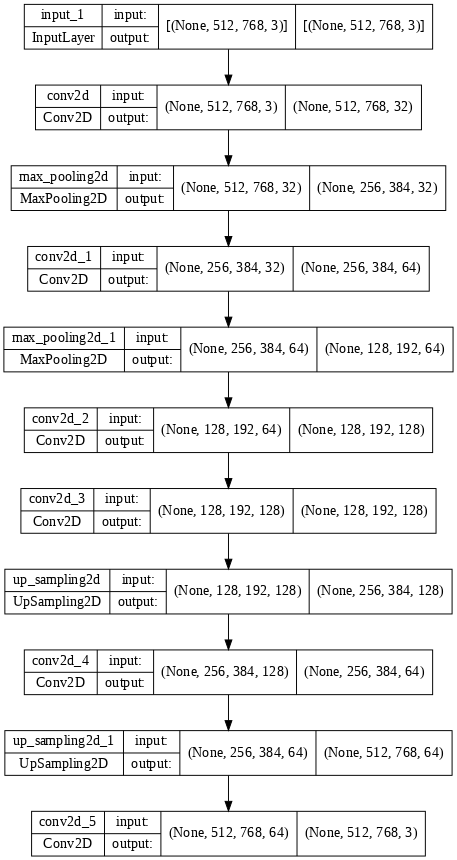

In [10]:
import tensorflow as tf
tf.keras.utils.plot_model(ae, show_shapes=True, dpi=70)

In [ ]:
#ae.to(device)
ae_train = ae.fit(train_x, train_y, batch_size=8,epochs=epochs,verbose=1,validation_data=(x_valid, y_valid))
loss = ae_train.history['loss']
val_loss = ae_train.history['val_loss']

Epoch 1/500
106/106 [==============================] - 33s 209ms/step - loss: 0.0058 - accuracy: 0.6696 - val_loss: 0.0041 - val_accuracy: 0.7194
Epoch 2/500
106/106 [==============================] - 20s 190ms/step - loss: 0.0030 - accuracy: 0.7285 - val_loss: 0.0022 - val_accuracy: 0.7943
Epoch 3/500
106/106 [==============================] - 20s 189ms/step - loss: 0.0024 - accuracy: 0.7792 - val_loss: 0.0016 - val_accuracy: 0.8090
Epoch 4/500
106/106 [==============================] - 20s 190ms/step - loss: 0.0020 - accuracy: 0.7980 - val_loss: 0.0017 - val_accuracy: 0.8200
Epoch 5/500
106/106 [==============================] - 20s 190ms/step - loss: 0.0018 - accuracy: 0.8067 - val_loss: 0.0039 - val_accuracy: 0.5524
Epoch 6/500
106/106 [==============================] - 20s 189ms/step - loss: 0.0018 - accuracy: 0.8147 - val_loss: 0.0017 - val_accuracy: 0.8142
Epoch 7/500
106/106 [==============================] - 20s 190ms/step - loss: 0.0016 - accuracy: 0.8325 - val_loss: 0.0014 -

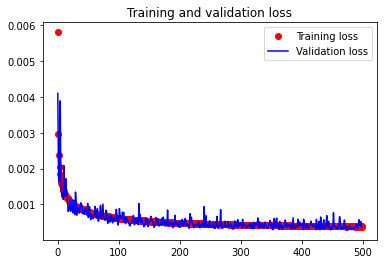

In [ ]:
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
pred = ae.predict(x_test)
x=(x_test[5])
k = cv2.cvtColor(x,cv2.COLOR_YCR_CB2RGB)
plt.imshow(k)
plt.show()


In [ ]:
x=(pred[5])
k = cv2.cvtColor(x,cv2.COLOR_YCR_CB2RGB)
plt.imshow(k)
plt.show()

In [ ]:
model_name = 'AE_model_unlabeled'
path = F"/content/gdrive/MyDrive/UOL files/Dissertation Project/AE_Models/{model_name}" 

In [ ]:
ae.save(path)

In [ ]:
#!zip -r /content/file.zip /content/Folder_To_Zip
#!zip -r /content/file.zip /content/gdrive/MyDrive/AE_Models/AE_model_unlabeled

  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/ (stored 0%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/assets/ (stored 0%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/variables/ (stored 0%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/variables/variables.index (deflated 67%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/keras_metadata.pb (deflated 92%)
  adding: content/gdrive/MyDrive/AE_Models/AE_model_unlabeled/saved_model.pb (deflated 89%)


### Testing

In [ ]:
# !cp -r "/content/gdrive/My Drive/Project/models/comp_model_downsized_flooded"   "/content/drive/MyDrive/Project/models/comp_model_downsized_flooded"

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model_name = 'AE_model_unlabeled'
path = F"/content/drive/MyDrive/UOL files/Dissertation Project/AE_Models/{model_name}" 

In [ ]:
new_model = tf.keras.models.load_model(path, compile=False)

In [ ]:
from matplotlib import pyplot

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))


# works

In [ ]:
def AE_Fl_pred(input_path, output_path, model):

  data=[]
  image_names = []

  for img in os.listdir(input_path):
      
      img_path = os.path.join(input_path,img)
      
      f, e = os.path.splitext(img)
      image_names.append(f)

      bgr_file = cv2.imread(img_path)#BGR
      ycr_file = cv2.cvtColor(bgr_file,cv2.COLOR_BGR2YCR_CB)
      data.append(ycr_file)

  #Normalize
  norm_file = np.array(data, dtype = np.float32)/255.0
  norm_file = norm_file.reshape(-1,512,768,3)

  #Make predictions
  preds = model.predict(norm_file)

  #Save file
  return preds, image_names

In [ ]:
def save_compressed_files(preds, image_names, output_path):
  
  for ind in range(len(preds)): 
    x=(preds[ind])
    k = cv2.cvtColor(x,cv2.COLOR_YCR_CB2RGB)
    k = normalize(k)
    pyplot.imsave(output_path + image_names[ind] + '.jpg', k)

**Train**

In [ ]:
'''
input_path = "/content/drive/MyDrive/Resized_Images/Train/Unlabeled/"
output_path = "/content/drive/MyDrive/Compressed_AE_UN_Images/"

AE_Fl_pred(input_path, output_path, new_model)
'''

**Test**

In [ ]:
input_path = "/content/drive/MyDrive/Resized_Images/Test/" 
output_path = "/content/drive/MyDrive/Compressed_AE_images/Test/" 

AE_Fl_pred(input_path, output_path, new_model)

**Validation**

In [ ]:
input_path = "/content/drive/MyDrive/Resized_Images/Validation/" 
output_path = "/content/drive/MyDrive/Compressed_AE_Images/Validation/"

In [ ]:
preds, image_names = AE_Fl_pred(input_path, output_path, new_model)

In [ ]:
preds

In [ ]:
image_names

In [ ]:
output_path = '/content/drive/MyDrive/Validation/'

In [ ]:
save_compressed_files(preds, image_names, output_path)